In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os

In [2]:
from PIL import Image
import pandas as pd

In [ ]:
x = np.zeros([106, 2112])
y = np.zeros(106)

train_filenames = os.listdir("datasets/HSE/train_cells")
classes = pd.read_csv("datasets/HSE/train_classes.csv", index_col="image")
j = 0

for i in range(len(train_filenames)):
    train_image = Image.open("datasets/HSE/train_cells/" + train_filenames[i])
    pixels_line = (np.asarray(train_image).flatten() / 255).astype(np.float32)
    class_name = df.loc[os.path.splitext(train_filenames[i])[0]]['class'].astype(np.uint8)
    if class_name == 29:
        class_name = 0 # A
    elif class_name == 23:
        class_name = 1 # Б
    else:
        continue
      
    x[j] = pixels_line
    y[j] = class_name
    j += 1
    
print(x.shape, y.shape)

In [164]:
x_train, x_test, y_train, y_test = x[:80], x[80:], y[:80], y[80:]
y_train = np.array([[1 if i == y_train[j] else 0 for i in range(2)] for j in range(len(y_train))])
y_test = np.array([[1 if i == y_test[j] else 0 for i in range(2)] for j in range(len(y_test))])

In [103]:
def sigmoid(x, derivative = False):
    if derivative:
        return np.exp(-x) / ((np.exp(-x) + 1) ** 2)
    else:
        return 1 / (1 + np.exp(-x))

In [104]:
def nn_init(lsize):
    input_layer  = lsize[0]
    hidden_1     = lsize[1]
    hidden_2     = lsize[2]
    output_layer = lsize[3]
    
    # narrowing down the standard deviation by layer size, with np.sqrt()
    # large layers have tighter initial values
    nnet = {
        'w0': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
        'w1': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
        'w2': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
    }
    return nnet

In [105]:
def softmax(x, derivative = False):
    # for stability, we shift values down so max = 0
    # https://cs231n.github.io/linear-classify/#softmax
    exp_shifted = np.exp(x - x.max())
    if derivative:
        return exp_shifted / np.sum(exp_shifted, axis = 0) * (1 - exp_shifted / np.sum(exp_shifted, axis = 0))
    else:
        return exp_shifted / np.sum(exp_shifted, axis = 0)

In [106]:
def forward_pass(x):
    # the model is a global var, used here read-only
    
    # NN state: internal sums, neuron outputs
    nn_state = {}
    
    # "output zero" is the output from receptors = input to first layer in the NN
    # these are activations for the input layer
    nn_state['o0'] = x
    
    # from input layer to hidden layer 1
    # weighted sum of all activations, then sigmoid
    nn_state['z1'] = np.dot(model['w0'], nn_state['o0'])
    nn_state['o1'] = sigmoid(nn_state['z1'])
    
    # from hidden 1 to hidden 2
    nn_state['z2'] = np.dot(model['w1'], nn_state['o1'])
    nn_state['o2'] = sigmoid(nn_state['z2'])
    
    # from hidden 2 to output
    nn_state['z3'] = np.dot(model['w2'], nn_state['o2'])
    nn_state['o3'] = softmax(nn_state['z3'])
    
    return nn_state

In [107]:
def part_cost(o, y):
    cost = 0
    for i in range(len(y)):
        cost += y[i]*np.log(o[i])+(1-y[i])*np.log(1-o[i])
    
#     c = np.dot(y, np.log(o)) + np.dot((1 - y), np.log(1 - o))
    return -cost

In [108]:
def backward_pass(x, y):
    # do the forward pass, register the state of the network
    nn_state = forward_pass(x)
    
    # small deltas: derivatives of the error w.r.t. z
    nn_state['d3'] = nn_state['o3'] - y
    nn_state['d2'] = np.dot(nn_state['d3'], model['w2']) * softmax(nn_state['z2'], derivative = True)
    nn_state['d1'] = np.dot(nn_state['d2'], model['w1']) * sigmoid(nn_state['z1'], derivative = True)
    
    # large deltas: adjustments to weights
    nn_state['D2'] = np.outer(nn_state['d3'], nn_state['o2'])
    nn_state['D1'] = np.outer(nn_state['d2'], nn_state['o1'])
    nn_state['D0'] = np.outer(nn_state['d1'], nn_state['o0'])
    
    return nn_state

In [218]:
layer_sizes = [2112, 512, 256, 2]
model = nn_init(layer_sizes)

In [219]:
epochs = 150
t_rate = 0.005

costs = []
accuracies = []

print('################### training ####################')
for e in tqdm(range(epochs)):
#     print('epoch:', e)
    
    samples = x_train.shape[0]
    cost = 0
    hit_count = 0
    
    for i in range(samples):
#         print(x_train[i])
        m_state = backward_pass(x_train[i], y_train[i])
        # add partial cost
#         print(m_state['o3'], y_train[i])
        cost += part_cost(m_state['o3'], y_train[i])
#         print(cost)
        
        # stochastic gradient descent update weights
        model['w0'] -= t_rate * m_state['D0']
        model['w1'] -= t_rate * m_state['D1']
        model['w2'] -= t_rate * m_state['D2']
        
        if np.argmax(m_state['o3']) == np.argmax(y_train[i]):
            hit_count += 1

    # performance evaluation
    cost = cost / samples
    accuracy = hit_count / samples
    costs.append(cost)
    accuracies.append(accuracy)
#     print('cost:', cost, 'accuracy:', accuracy)

total_cost = cost
total_accuracy = accuracy
print(total_cost, total_accuracy)

# save the model
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

################### training ####################


100%|█████████████████████████████████████████| 150/150 [01:30<00:00,  1.65it/s]

0.47673938225676443 0.975


<function matplotlib.pyplot.show(close=None, block=None)>

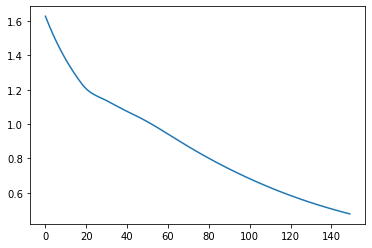

In [220]:
plt.plot(np.arange(epochs), np.array(costs))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

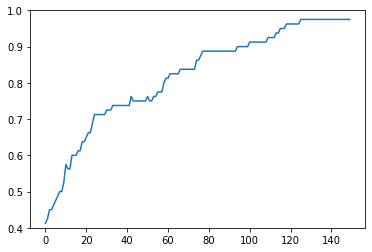

In [221]:
plt.plot(np.arange(epochs), np.array(accuracies))
axis = plt.gca()
axis.set_ylim([0.4, 1.])
plt.show

In [222]:
# test
print('################### testing ####################')
# load the model
if os.path.isfile('model.pickle'):
    with open('model.pickle', 'rb') as f:
        model = pickle.load(f)

# run the whole test data
samples = x_test.shape[0]
cost = 0
hit_count = 0
for i in tqdm(range(samples)):
    m_state = forward_pass(x_test[i])
    cost += part_cost(m_state['o3'], y_test[i])
    if np.argmax(m_state['o3']) == np.argmax(y_test[i]):
        hit_count += 1

# evaluate performance
cost = cost / samples
accuracy = float(hit_count) / float(samples)
print('cost:', cost, 'accuracy:', accuracy)

################### testing ####################


100%|██████████████████████████████████████████| 26/26 [00:00<00:00, 592.25it/s]

cost: 0.9413403867201832 accuracy: 0.8461538461538461


In [110]:
def predict(image):
    if os.path.isfile('model.pickle'):
        with open('model.pickle', 'rb') as f:
            model = pickle.load(f)
    
    m_state = forward_pass(image)
    return np.argmax(m_state['o3'])

1


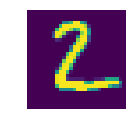

In [122]:
digit = x_test[1]

digit_pixels = digit.reshape(28, 28)
plt.subplot(131)
plt.imshow(digit_pixels)
plt.axis('off')

result = predict(digit)
print(result)